<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [3]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [4]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[0] #Normal
test_file = file_path+file[1]
dataset= "Normal"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 358), (11403, 358), (75818, 358))

In [115]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred)
    auc = metrics.roc_auc_score(y_true,y_pred)
    log_loss = metrics.log_loss(y_true,y_pred)
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])


    
    

  else:
    plt.figure(figsize=(12,8))
    for i,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[i]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()


  


# Modeling

In [6]:
def find_best_params(model,params,cv=10,n_jobs=-1):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


The best auc score was 0.798
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 8.86 s, sys: 288 ms, total: 9.15 s
Wall time: 1min 42s


LogisticRegression(C=0.001, class_weight='balanced')

In [7]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced')

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal dataset 		 



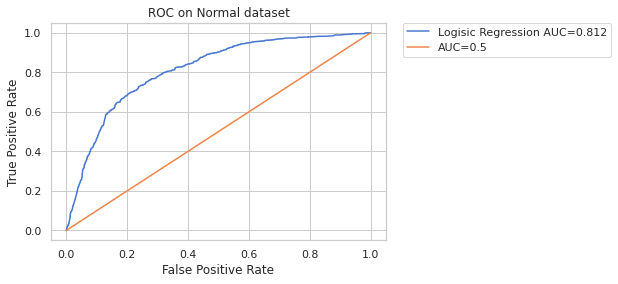

The log loss and auc was found to be 0.542 and 0.812 for Logisic Regression on Normal dataset.


In [8]:
i=0
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.7min finished


The best auc score was 0.762
The best params were: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 500, 'max_depth': 10}
CPU times: user 5.23 s, sys: 392 ms, total: 5.62 s
Wall time: 5min 44s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=500,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=10,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal dataset 		 



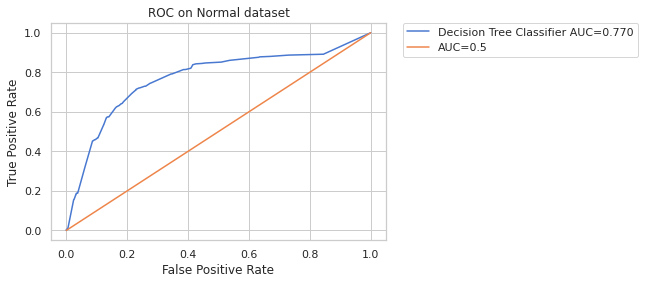

The log loss and auc was found to be 0.149 and 0.770 for Decision Tree Classifier on Normal dataset.


In [11]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [12]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[500,1000,2000],
          'max_depth':[500,1000,2000], 
         'min_samples_split':[100,500,1000],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250,500] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed: 54.3min remaining:  6.0min
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed: 54.6min finished


The best auc score was 0.817
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 2000}
CPU times: user 6min 5s, sys: 1.17 s, total: 6min 6s
Wall time: 1h 44s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=10, oob_score=False,
                       verbose=0, warm_start=False)


model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=10, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal dataset 		 



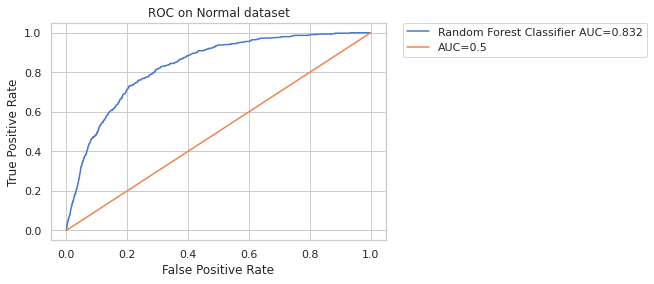

The log loss and auc was found to be 0.138 and 0.832 for Random Forest Classifier on Normal dataset.


In [15]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [16]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027


# XGB Classifier

In [130]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=100,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5,
                     )
#validation_0-auc:0.84556

In [131]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.738439	validation_0-error:0.039726
[1]	validation_0-auc:0.814115	validation_0-error:0.039551
[2]	validation_0-auc:0.810379	validation_0-error:0.039551
[3]	validation_0-auc:0.821142	validation_0-error:0.039551
[4]	validation_0-auc:0.818471	validation_0-error:0.039551
[5]	validation_0-auc:0.818156	validation_0-error:0.039551
[6]	validation_0-auc:0.819139	validation_0-error:0.039551
[7]	validation_0-auc:0.819947	validation_0-error:0.039551
[8]	validation_0-auc:0.81811	validation_0-error:0.039551
[9]	validation_0-auc:0.816234	validation_0-error:0.039551
[10]	validation_0-auc:0.818551	validation_0-error:0.039551
[11]	validation_0-auc:0.821835	validation_0-error:0.039551
[12]	validation_0-auc:0.822149	validation_0-error:0.039551
[13]	validation_0-auc:0.822641	validation_0-error:0.039551
[14]	validation_0-auc:0.821571	validation_0-error:0.039551
[15]	validation_0-auc:0.821215	validation_0-error:0.039551
[16]	validation_0-auc:0.825202	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [29]:
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=np.nan,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9, tree_method='exact', validate_parameters=1)

%time model.fit(X_train,y_train)

CPU times: user 1min 27s, sys: 258 ms, total: 1min 27s
Wall time: 44.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=5, gpu_id=0,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=1)

		 XGBoost Classifer on Normal dataset 		 



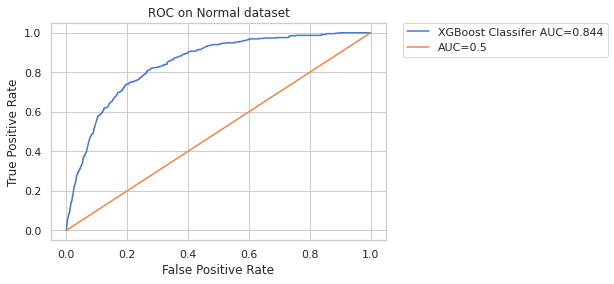

The log loss and auc was found to be 0.133 and 0.844 for XGBoost Classifer on Normal dataset.


In [32]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [33]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133362,0.844455


# LightGBM Classifier

In [144]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,
                     )
#valid_0's auc: 0.845998

In [141]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.163975	valid_0's auc: 0.794588
[2]	valid_0's binary_logloss: 0.161881	valid_0's auc: 0.820176
[3]	valid_0's binary_logloss: 0.160515	valid_0's auc: 0.825028
[4]	valid_0's binary_logloss: 0.159927	valid_0's auc: 0.826959
[5]	valid_0's binary_logloss: 0.159631	valid_0's auc: 0.827058
[6]	valid_0's binary_logloss: 0.159736	valid_0's auc: 0.826822
[7]	valid_0's binary_logloss: 0.159746	valid_0's auc: 0.82863
[8]	valid_0's binary_logloss: 0.160218	valid_0's auc: 0.828514
[9]	valid_0's binary_logloss: 0.160594	valid_0's auc: 0.829355
[10]	valid_0's binary_logloss: 0.161187	valid_0's auc: 0.830235
[11]	valid_0's binary_logloss: 0.162073	valid_0's auc: 0.83049
[12]	valid_0's binary_logloss: 0.162837	valid_0's auc: 0.831669
[13]	valid_0's binary_logloss: 0.163923	valid_0's auc: 0.83243
[14]	valid_0's binary_logloss: 0.164881	valid_0's auc: 0.832882
[15]	valid_0's binary_logloss: 0.166069	valid_0's auc: 0.832959
[16]	valid_0's binary_logloss: 0.167288	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0,
               scale_pos_weight=24.270629644114198, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

In [142]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train.values,y_train)

CalibratedClassifierCV(base_estimator=LGBMClassifier(boosting_type='gbdt',
                                                     class_weight=None,
                                                     colsample_bytree=0.5,
                                                     gamma=5,
                                                     importance_type='split',
                                                     learning_rate=0.01,
                                                     max_depth=7,
                                                     min_child_samples=20,
                                                     min_child_weight=0.001,
                                                     min_split_gain=0.0,
                                                     n_estimators=500,
                                                     n_jobs=-1, nthread=-1,
                                                     num_leaves=31,
                                                     object

In [101]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=y_train.sum(),
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5,
                     )

%time model.fit(X_train,y_train)

CPU times: user 1min 9s, sys: 230 ms, total: 1min 9s
Wall time: 36.1 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal dataset 		 



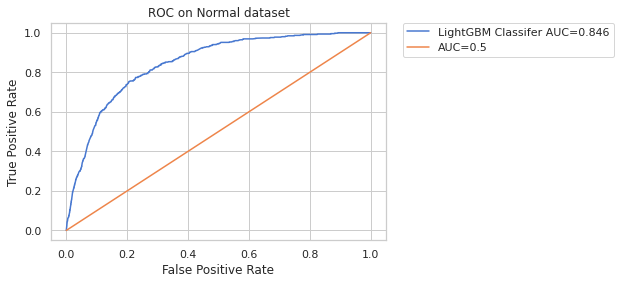

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Normal dataset.


In [102]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [103]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133362,0.844455
4,LightGBM Classifer,Normal,0.133201,0.845998


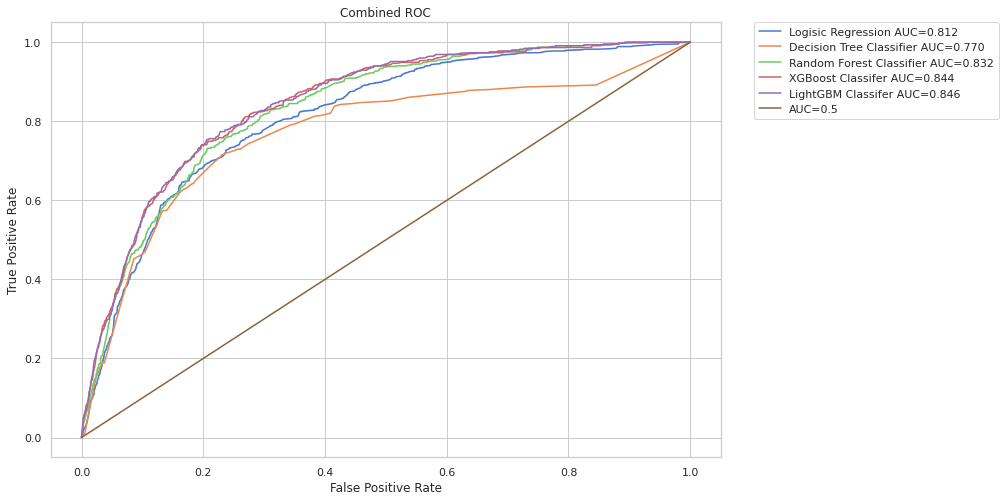

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal,0.541973,0.812374
1,Decision Tree Classifier,Normal,0.149154,0.769659
2,Random Forest Classifier,Normal,0.137582,0.832027
3,XGBoost Classifer,Normal,0.133362,0.844455
4,LightGBM Classifer,Normal,0.133201,0.845998


In [117]:
plot_auc(y_val,y_preds,labels)
result_df